# Training Latent Graph Autoencoder

In [1]:
import torchvision
import torch
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data.dataloader import DataLoader
from graph_autoencoder import LatentGraphVAE
import matplotlib.pyplot as plt
import numpy as np

/home/bglaze/miniconda3/envs/graph_autoencoder/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:1'

In [3]:
transforms = Compose([
    ToTensor(),
    Resize((320//2, 480//2))
    ])
dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
dataloader = DataLoader(dataset=dataset, batch_size=1)

In [4]:
lgvae = LatentGraphVAE(n_channels=3, w=320//2, h=480//2, device=device).to(device)
optim = torch.optim.Adam(params=lgvae.parameters())

optim.zero_grad()
batch_size = 100
n_epochs = 1
i=0
batch_loss = 0
checkpoint = 1000

tmstp = '20221201_1342'

for epoch in range(n_epochs):
    i=0
    for image,_ in dataloader:
        image = image.squeeze(0).to(device)
        nodes = lgvae(image)
        recon = nodes.sum(dim=0)
        loss = torch.mean((recon - image)**2)
        loss.backward()
        batch_loss += float(loss)/batch_size
        i+=1
        if i%batch_size==0:
            optim.step()
            optim.zero_grad()
            print(f"epoch={epoch:4d} n={i:8d} loss={batch_loss:8.4f}", flush=True)
            batch_loss = 0
        if i%checkpoint==0:
            torch.save(lgvae.state_dict(), f'models/lgvae_{tmstp}.torch')

/home/bglaze/miniconda3/envs/graph_autoencoder/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch=   0 n=     100 loss= 10.0534
epoch=   0 n=     200 loss=  9.9986
epoch=   0 n=     300 loss=  9.6177
epoch=   0 n=     400 loss=  8.6714
epoch=   0 n=     500 loss=  7.6243
epoch=   0 n=     600 loss=  7.5042
epoch=   0 n=     700 loss=  6.6845
epoch=   0 n=     800 loss=  5.9855
epoch=   0 n=     900 loss=  5.2118
epoch=   0 n=    1000 loss=  4.0846
epoch=   0 n=    1100 loss=  2.7369
epoch=   0 n=    1200 loss=  1.3489
epoch=   0 n=    1300 loss=  0.4000
epoch=   0 n=    1400 loss=  0.1724
epoch=   0 n=    1500 loss=  0.2003
epoch=   0 n=    1600 loss=  0.2160
epoch=   0 n=    1700 loss=  0.2207
epoch=   0 n=    1800 loss=  0.2175
epoch=   0 n=    1900 loss=  0.2192
epoch=   0 n=    2000 loss=  0.2207
epoch=   0 n=    2100 loss=  0.2204
epoch=   0 n=    2200 loss=  0.2190
epoch=   0 n=    2300 loss=  0.2197
epoch=   0 n=    2400 loss=  0.2211
epoch=   0 n=    2500 loss=  0.2181
epoch=   0 n=    2600 loss=  0.2215
epoch=   0 n=    2700 loss=  0.2189
epoch=   0 n=    2800 loss= 

KeyboardInterrupt: 

In [5]:
def to_np(tnsr):
    return tnsr.detach().cpu().numpy().transpose((1,2,0))

In [6]:
val_dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
iter_val_loader = iter(val_loader)

tensor(-1.5413e-08, device='cuda:1')


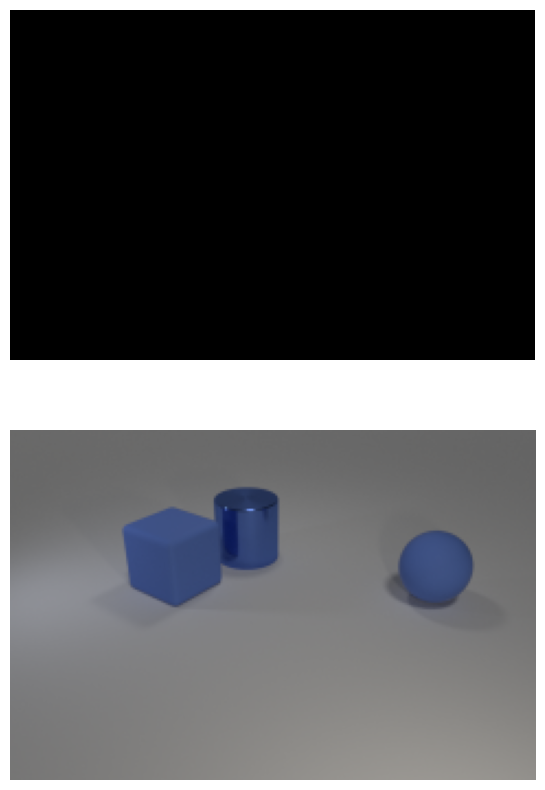

In [31]:
fig, axs = plt.subplots(2,1, figsize=(10,10))

with torch.no_grad():
    val_recons = []
    for i in range(10):
        val_image,_ = next(iter_val_loader)
        val_image = val_image.squeeze(0).to(device)
        val_nodes = lgvae(val_image)
        val_recon = val_nodes.sum(dim=0)
        val_nprecon = to_np(val_recon)
        val_recons.append(val_recon)
    print((val_recons[8] - val_recons[2]).sum())
    axs[0].axis('off')
    axs[0].imshow(val_nprecon)
    axs[1].axis('off')
    axs[1].imshow(to_np(val_image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


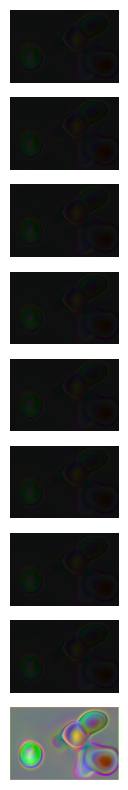

In [146]:
n_nodes = nodes.shape[0]
fig, axs = plt.subplots(n_nodes+1, figsize=(40,10))
for i in range(n_nodes):
    node_np = to_np(nodes[i])
    axs[i].axis('off')
    axs[i].imshow(node_np, interpolation='none')
axs[n_nodes].axis('off')
axs[n_nodes].imshow(to_np(recon))

In [152]:
to_np(nodes[0]).shape

(160, 240, 3)